# MNIST Neural Network

**Author: [Kevin Broløs](https://abzu.ai/team)**

In this notebook, we'll use a neural network to solve the MNIST handwritten digits dataset, which is an image classification problem.

# Dependencies

Those of you new to jupyter notebooks:
Either click the >| Run button or Shift+Enter to step through each cell, or the >> button to restart and run all cells

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display, clear_output
from sklearn import model_selection
import numpy as np

# In order to ignore FutureWarning from TensorFlow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42
np.random.seed(random_state)

# includes a class PlotCallback that helps plot our neural network training output
import plot_helper

### Reproducible results

I haven't locked the random state in this notebook, so the results may vary from machine to machine (and from run to run!)

# Load the MNIST dataset from keras datasets

This can take a while as there's a lot of images being downloaded.

These files will be downloaded to '~/.keras/datasets/' + path). More information [here](https://keras.io/datasets/).

In [2]:
from tensorflow.keras.datasets import mnist

(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

## What is MNIST?

While we wait for the download, let's go over the dataset a bit.

The MNIST handwritten digit set is a dataset of 28x28 grayscale images of the 10 digits (0-9). Each of these images has been classified by a human and is a good learning example for machine learning projects.

It's particularly easy to work on because it's been standardized so heavily. All images are 28x28 pixels, and they are all greyscale, which makes it really easy to work on and visualize.

That means each image is going to be fitted into the model as a 28x28 matrix of numbers between 0-255, or rather, a 784 long vector of numbers between 0-255. It's a bit counter-intuitive that the machine can make sense of this format (and indeed, there are more well-suited methods for exactly this reason where we want it to more accurately pick up patterns in the image), but for now it suffices that each image is processed in the same way, and it will treat each pixel in the image as an information source that can be more or less activated.

## Dataset reduction

To make the training faster for this course, we'll reduce the amount of data we'll work on from the available 60.000 images to just 1000.

We'll also only focus on some digits, and build from there.

### Exercises
**You can add more digits to classify below during the exercises (at the end of the notebook), and also increase or decrease the training and test size. (Test set maximum is 10.000).**

In [3]:
digits = np.array([0, 1, 4, 7]) # Add or remove numbers here to try classifying other numbers

In [4]:
# Number of samples for training and test. Consider adding more if classifying more numbers.
num_elements_train = 500*len(digits)    # Number of samples in the training set
num_elements_test = 500*len(digits)     # Number of samples in the test set

# Select only the digits in the training set we want
train_mask = np.isin(y_train_full, digits) 

#Apply the selection - and then take the num_elements from the resulting set
x_train_subset = x_train_full[train_mask][:num_elements_train] 
y_train_subset = y_train_full[train_mask][:num_elements_train]

# Do the same for the test set
test_mask = np.isin(y_test_full, digits)
x_test_subset = x_test_full[test_mask][:num_elements_test]
y_test_subset = y_test_full[test_mask][:num_elements_test]

## Plotting our training data

Let's plot some of the handwritten digit data we've selected to train on

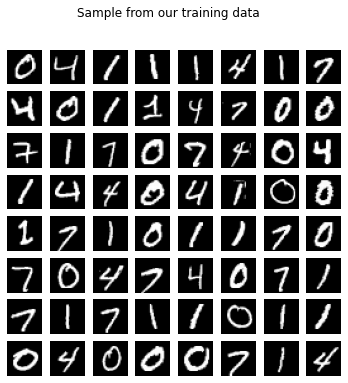

In [5]:
rows, cols, img_size = 8, 8, x_train_subset.shape[1]
fig = plt.figure(figsize=(6, 6))

fig.suptitle('Sample from our training data')
for i in range(rows):
    for j in range(cols):
        index = (i*rows)+j
        plt.subplot(rows, cols, index+1)
        plt.imshow(x_train_subset[index], cmap='gray')
        plt.axis('off')

Above is a picture of the first few handwritten digits in our dataset, so you can see what we'll feed into the model

# Encoding of output column

In order to make it easier for the network to learn, we use a process called "one-hot encoding", "one of k encoding" or "dummy variables". The process is basically about taking a category (the numbers 0-9) and instead of representing it as a single field with the numbers 0-9 (label encoding), we represent it as 10 separate categories that are exclusively 0 or 1 (one-hot encoding).

As an example:

    | digit |
    | 1     |
    | 7     |
    | 3     |
    
turns into:

    | digit_0 | digit_1 | digit_2 | digit_3 | digit_4 | digit_5 | digit_6 | digit_7 | digit_8 | digit_9 |
    | 0       | 1       | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 0       |
    | 0       | 0       | 0       | 0       | 0       | 0       | 0       | 1       | 0       | 0       |
    | 0       | 0       | 0       | 1       | 0       | 0       | 0       | 0       | 0       | 0       |

You'll notice it's more verbose. 

When preparing both input and output, we need to ensure that they're numerical for the machine to work on them. We can do that by using "label encoding" where "One" maps to 1, "Two" maps to 2, etc. The pitfall of this is that when we do that, we introduce an ordering between elements. It will appear that higher numbers are more important than lower numbers - and in our case it is clearly non-sensical. We're representing 10 discrete digits and they have no ordering or relationship between them in this case.

If we were to label encode them anyway, it could lead to worse learning and weird results as it may find unexpected relationships between the numbers themselves, rather than treating them as categories.

One-hot encoding as above is a way to encode the categories such that we avoid this interpretation of the arbitrary label number order, but it comes at a cost of added dimensions (1 field turns into 10 in this case. But this could easily be hundreds for other problems!).

This is only required for some machine learning methods, but almost always necessary for neural networks - depending on the amount of classes and the difficulty of the problem.

In [6]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the output vectors using an inbuilt function of keras
y_train = to_categorical(y_train_subset)
y_test = to_categorical(y_test_subset)

# Print out the shape of the resulting vectors so we can see how they look
print("Dataset split:")
print("x_train", x_train_subset.shape)
print("y_train", y_train.shape)
print("x_test", x_test_subset.shape)
print("y_test", y_test.shape)

Dataset split:
x_train (2000, 28, 28)
y_train (2000, 8)
x_test (2000, 28, 28)
y_test (2000, 8)


## Normalization

For most neural networks, it is recommended to normalize the input data to values between 0 and 1. This greatly improves learning, and gets rid of any discrepancies in values that have vastly different scales. In our case it doesn't make any difference in terms of discrepancies, but will make the network more well behaved in general, as the influences of weights and biases will be more subtle.

In our case, we also arrange our (28, 28) shape into a contiguous vector of 784 pixels for training as mentioned earlier.

In [7]:
# Calculate the input features as 28*28
input_features = x_train_subset.shape[1]*x_train_subset.shape[2]

from sklearn.preprocessing import normalize

# Reshape the training set from (num_samples, 28, 28) to (num_samples, 784) before normalizing
x_train = normalize(x_train_subset.reshape(-1, input_features))
x_test = normalize(x_test_subset.reshape(-1, input_features))

## Construct a simple neural network with Keras

We start by initializing a sequential Keras model, which is one of Keras' many ways of building models.
Layers are added to this by calling `model.add(<layer>)` in sequence, and the model is finalized by calling `model.compile`.

We then define the layers of the network.
- Dense: creates a fully connected (dense) layer of neurons.
- input_dim: specifies the amount of input neurons. If you don't specify it will use the output of the previous layer.
- activation: The activation function to use. We haven't covered activation functions much, but they help the network achieve more than just linear solutions to problems. They have different features and affect both the learning speed and result in remarkable ways. You don't have to worry about it for this exercise, but know they exist.

### Exercises

**During the exercises, this is where you can start playing with the network structure to get a feel for how it works.**

You can either add more layers (for instance by commenting in the "hidden layer" below). Remember to both define the layer with the `Dense()` function, and add it to the model using `model.add(<layer>)`.

Try experimenting with different values of the `hidden_layer_neurons` parameter.

For advanced students

- try adding `Dropout` to the network between some of the layers, and adjust the dropout rate to get a feel for how it affects the performance of the network. You can find the `dropout_rate` variable and some commented lines below for how to add the keras `Dropout()` function to the network. (Try googling Keras Dropout to understand how it works).

In [8]:
output_features = y_test.shape[1] # The amount of handwritten digits we're classifying!
activation_function = 'sigmoid' # 'relu' and 'sigmoid' are two good options

first_layer_neurons = 10
#hidden_layer_neurons = 100 ## Comment this in if adding another hidden layer.

#dropout_rate = 0.3 ## ADVANCED: Comment this in if adding dropout

In [9]:
# Initialize a sequential keras model and define the layers of the network. 
# For the exercises, you can try to add and remove layers here. 
model = Sequential(name="MNIST_Digit_Classifier", layers=[
    Dense(first_layer_neurons, input_dim=input_features, activation=activation_function),
    #Dropout(dropout_rate), ## ADVANCED: Comment this in if adding dropout. Try experimenting between layers
    
    #Dense(hidden_layer_neurons, activation=activation_function),
    #Dropout(dropout_rate),
    Dense(output_features, activation='softmax')
])

# Bake the model with a loss function and optimizer. You shouldn't have to change this for the exercises
model.compile(
    # the loss function determines how far "off" the model is when comparing results
    loss='categorical_crossentropy',
    # The optimizer is in charge of stepping and updating the weights according to the gradient step in learning
    # Don't worry about it too much in this example.
    optimizer='Adam',
    metrics=['accuracy']
)

model.summary()

Model: "MNIST_Digit_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
Total params: 7,938
Trainable params: 7,938
Non-trainable params: 0
_________________________________________________________________


# Let's visualize the network for comparison's sake

This is pretty nonstandard - people usually rely on the summary to understand their networks. But I've created this helper function using graphviz that we also used for visualizing our decision trees, trying to make the summary a little more understandable.

It truncates for networks with more than 10 units in a layer

If you don't have graphviz installed, either ensure you do, or skip this step.

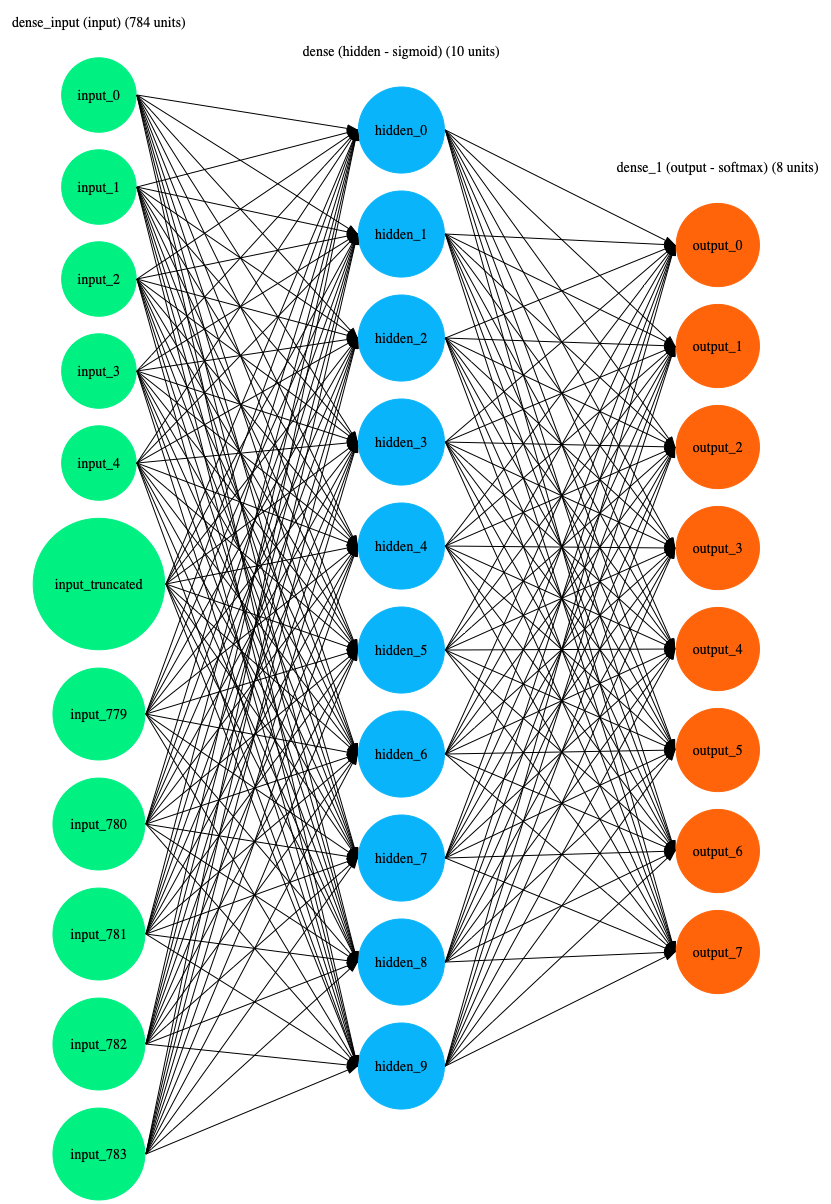

In [10]:
plot_helper.render_network(model, width=1000, height=600, retina=False, max_units=10, merge_dropout=True)

## Training the neural network

### Exercises

During the exercises, try experimenting with the max epochs (You can also run this cell multiple times to train it for another 20 epochs)

You can also experiment with the validation split, which is a piece of the training set it uses to give you hints on how well it will generalize.

For advanced students

- Try experimenting with the batch size i the `model.fit` call as explained in the exercises.

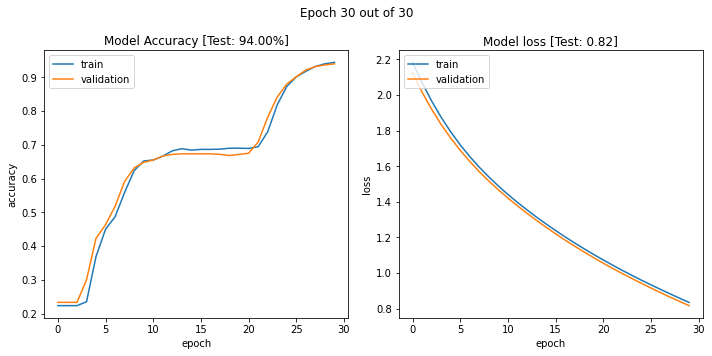

In [11]:
# The amount of iterations to train for
max_epochs=30

# This parameter further splits out 30% of the data for validation during training
validation_split = 0.3

plot_callback = plot_helper.PlotCallback(max_epochs, print_every=5)
fitted_model = model.fit(x_train, y_train,
                         batch_size=100,
                         epochs=max_epochs,
                         verbose=0,
                         validation_split=validation_split,
                         callbacks=[plot_callback])    

We need to do a bit more work to get the estimates out of the network.
Softmax returns probabilities for each class, so we need to convert them to a definitive answer to plot the confusion matrix

One way to do this is to use the np.argmax function on each row (from the numpy package).
Argmax returns the INDEX of the element with the highest value in an array. As our result is an array of arrays, this is a way to select the element with the highest probability.


In [12]:
# Get results from model
y_est_test = model.predict(x_test.reshape(-1, input_features))

# Get the highest probability class for each of the answers
y_est_test = np.argmax(y_est_test, axis=1)
y_est_test

# Convert the one-hot vector back into numbers
y_test_comp = np.argmax(y_test, axis=1)

## Calculate the Accuracy of the holdout set

In [13]:
generalization_error = np.sum(y_est_test != y_test_comp) / len(y_test_comp)
print("Accuracy of the classifier on the test set: {:.2f}%".format(100 * (1 - generalization_error)))

Accuracy of the classifier on the test set: 93.05%


# Plot a confusion matrix

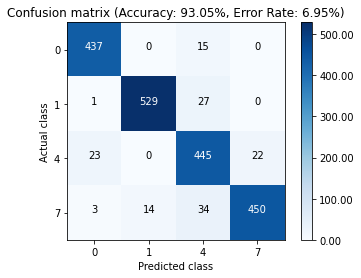

In [14]:
from sklearn.metrics import confusion_matrix

# Build a confusion matrix from the test set and the model results
cm = confusion_matrix(y_test_comp, y_est_test, labels=digits)

# We're using a custom made confusion matrix function since the sklearn one only supports skleanr estimators
plot_helper.plot_confusion_matrix(cm, digits)


# Exercise

This problem is relatively solvable with some tricks for a regular Feed Forward Neural Network, but is more easily solved using more advanced techniques for specifically image-related problems like Convolutional Neural Networks.

You should, however, be able to get somewhere around 95% accuracy (or even above!).

Don't worry if you don't understand every single bit. This is a bit more advanced and we've introduced some terms and techniques we haven't discussed, such as normalization and one-hot encoding. So there's a lot to take in.
The network structure itself, however, is very similar to the previous example going through the Iris dataset.

1. Run the code and read through it to get a feel for what it does
    1. Reflect: Take a look at the training graphs. 
        1. Does it seem to be learning well? 
        1. Is it overfitting to the data? 
        1. Has it trained sufficiently?
    1. Reflect: Take a look at the confusion matrix.
        1. Is there some classes it is especially struggling with? 
        1. Why do you think that is?
1. Play with the hyper parameters and try to improve your test score.
    1. Try running more/less epochs
    1. Try different sizes for the training/test set (Beware, increasing it too much can make it very slow as we're running on CPU's)
    1. Try adding more layers
    1. Try experimenting with the amount of neurons in each layer
1. Try adding more digits to classify. You'll notice the problem might get harder as you add more digits.
    1. Add more digits one at a time and reflect on the difference in quality of the model, and why that might be.
    1. Are some digits harder than other to discern between? Why?

### Advanced

1. Try increasing the model quality by adding Dropout (google will be helpful)
    1. Does it help? Why/Why not?
1. Try adjusting the batch size of the model fit (16-100 is probably a good range).
    1. Does it have an effect? Which?


Notes:

**Dropout** is a special kind of mechanism that randomly resets neurons in the network to try to regularize more and prevent overfitting. It can be a very effective tool on achieving a higher test score - but this is also why we split our data in a training, validation AND test set. As you keep chasing a higher validation score, you're indirectly biasing your network with your choices - and keeping the final set for testing safeguards you against that.

**Batch size** affects the training update speed, as well as memory usage and computational speed. It essentially defines how many samples it tries to fit on before doing a learning pass and updating the gradients with the information is has received. Since it averages over the samples, reducing the batch size will make it more prone to learn from the specific samples rather than the "true" gradient of the entire set, so will tend to have more bias towards those samples, whereas a larger batch size will be more even, but comes at a computational cost. 

Using a large batch (for instance with all the samples), will also tend to train slower because it has less updates of the weights. A small batch will train faster due to more updates of the network - but because the gradient is (even) more of an approximation of the true function, it will fluctuate more and be more sensitive to individual samples in the batches.

There's no real answer on what to use, but you can use your intuition in terms of memory use, computational speed, trying to distribute the batches to an even amount of splits - and then use trial and error and record your attempts.
    

- Remember to take notes of your configurations and their results. (You can do that in this cell even, by double clicking it and writing here, as you would code!)
- Reflect on the results.


What is the best test accuracy you're able to get?

## Additional resources

This blog post has a good runthrough on not only how to create this, but how to implement it as a CNN (which we have not covered here)
https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

For those interested in a good visual video series on neural networks and how they work (as well as how the math behind training checks out), I highly recommend going through these videos on Youtube, by 3Blue1Brown: https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi